In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
# Load dataset
df = pd.read_csv('Urban Sound Dataset.csv')  # Ensure this file is in the same directory as your Jupyter notebook
print(df.head())

   ID         Class
0   0         siren
1   1  street_music
2   2      drilling
3   3         siren
4   4      dog_bark


In [3]:
# Verify all audio files exist
missing_files = []
for idx, row in df.iterrows():
    file_path = os.path.join('Train', f"{row['ID']}.wav")
    if not os.path.exists(file_path):
        missing_files.append(file_path)

if missing_files:
    print(f"Missing files: {missing_files}")
else:
    print("All files are present.")

All files are present.


In [4]:
# Feature extraction function
def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        return mfccs.T  # Transpose to match time steps as rows
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [5]:
# Extract features and labels
features = []
labels = []

for idx, row in df.iterrows():
    file_path = os.path.join('Train', f"{row['ID']}.wav")
    mfccs = extract_features(file_path)
    if mfccs is not None:
        features.append(mfccs)
        labels.append(row['Class'])

E:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
E:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
E:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [6]:
# Pad sequences to ensure uniform input shape
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_seq_length = max([feature.shape[0] for feature in features])  # Find the max sequence length
padded_features = pad_sequences(features, maxlen=max_seq_length, padding='post', dtype='float32')


In [7]:
# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded)

In [8]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_features, labels_encoded, test_size=0.2, random_state=42)

In [9]:
# Build RNN Model
model = Sequential()

# LSTM Layers
model.add(LSTM(128, return_sequences=True, input_shape=(max_seq_length, 40)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(labels_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


E:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)


Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - accuracy: 0.2333 - loss: 2.1192 - val_accuracy: 0.4678 - val_loss: 1.5937
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.4903 - loss: 1.4642 - val_accuracy: 0.5713 - val_loss: 1.2324
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.5899 - loss: 1.1781 - val_accuracy: 0.6414 - val_loss: 1.0141
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.6323 - loss: 1.0656 - val_accuracy: 0.6540 - val_loss: 0.9697
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.6668 - loss: 0.9990 - val_accuracy: 0.6333 - val_loss: 1.0447
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.6756 - loss: 0.9348 - val_accuracy: 0.6759 - val_loss: 0.9334
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.6784 - loss: 0.9521 - val_accuracy: 0.6966 - val_loss: 0.8796
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.7125 - loss: 0

In [11]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7988 - loss: 0.6517
Test Loss: 0.6354488730430603, Test Accuracy: 0.8150873780250549


In [12]:
# Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


In [13]:
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.89      0.95      0.92       133
        car_horn       0.61      0.79      0.69        48
children_playing       0.69      0.81      0.75       107
        dog_bark       0.78      0.69      0.73       117
        drilling       0.91      0.67      0.77       133
   engine_idling       0.90      0.89      0.90       130
        gun_shot       0.70      0.95      0.81        40
      jackhammer       0.84      0.94      0.89       145
           siren       0.92      0.85      0.88       112
    street_music       0.74      0.64      0.69       122

        accuracy                           0.82      1087
       macro avg       0.80      0.82      0.80      1087
    weighted avg       0.82      0.82      0.81      1087



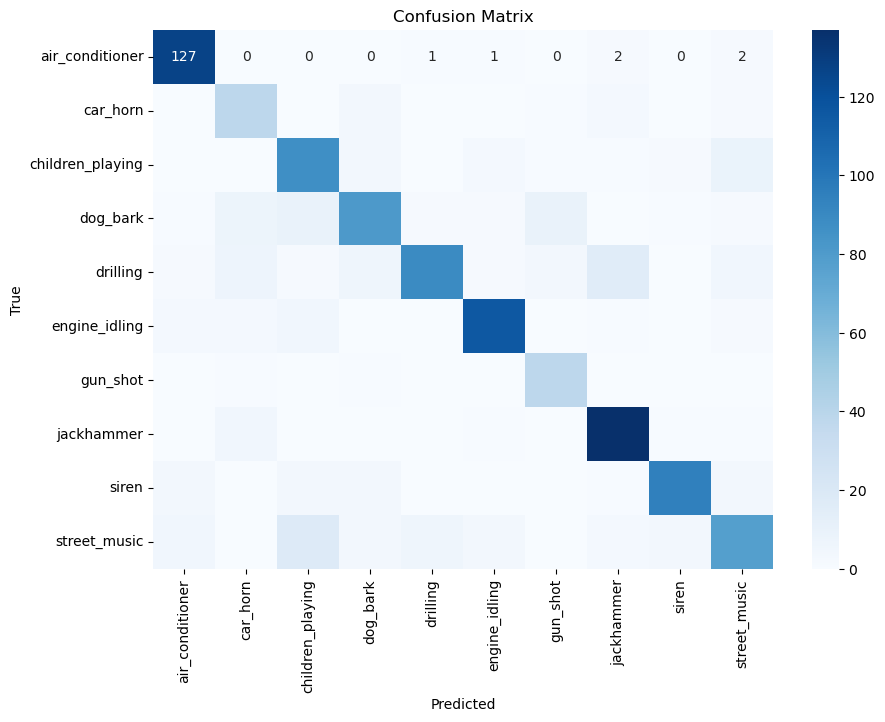

In [14]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

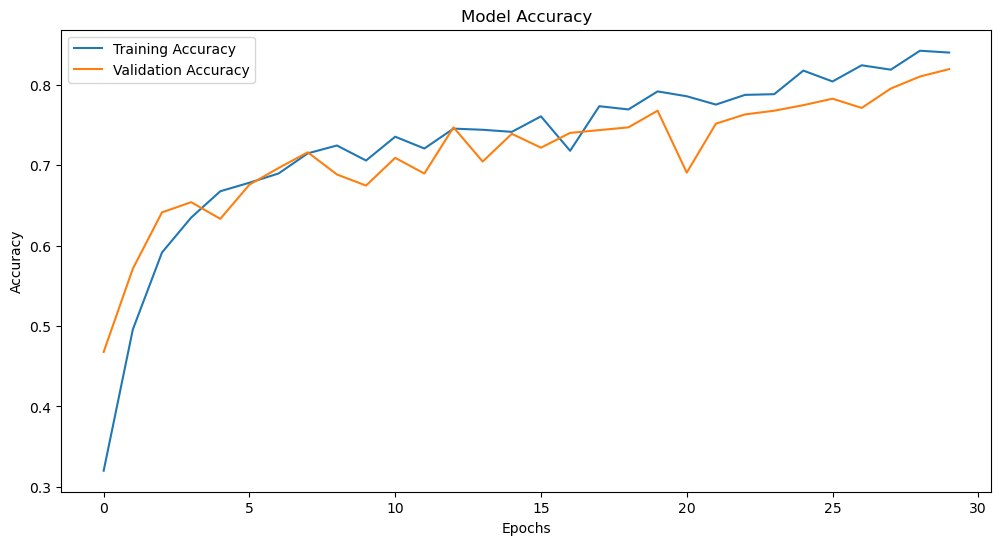

In [15]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

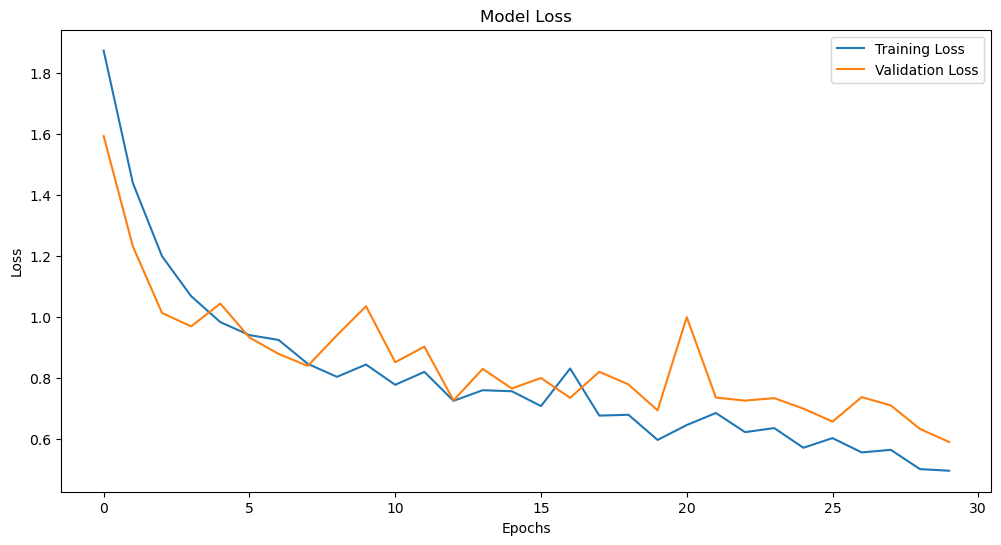

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()